In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from auto_clusters import kmeans_auto_clusters, pendiente

In [2]:
# Load the data
df = pd.read_excel('../data/processed/coprolitos_processed.xlsx')

# Inspeccionar primeros elementos
df.head()

,Ejemplar,Numero_de_inclusiones,Agujeros,Lineas_de_corrosion,Señal_quimica,Diametro_mm,Arreglo_de_inclusiones,Forma_de_fracturas_en_terminaciones
0,bump headed lace,4,2,1,1,1,2,5
1,bump headed lace,4,2,2,1,1,2,3
2,circular,1,2,1,1,1,4,5
3,circular,3,2,2,1,2,4,5
4,cilíndrico,1,2,1,1,3,1,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Ejemplar                             23 non-null     object
 1   Numero_de_inclusiones                23 non-null     int64 
 2   Agujeros                             23 non-null     int64 
 3   Lineas_de_corrosion                  23 non-null     int64 
 4   Señal_quimica                        23 non-null     int64 
 5   Diametro_mm                          23 non-null     int64 
 6   Arreglo_de_inclusiones               23 non-null     int64 
 7   Forma_de_fracturas_en_terminaciones  23 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 1.6+ KB


In [4]:
# Seleccionar las columnas relevantes para la reducción de dimensiones
data = df.select_dtypes(include=[int, float])  # Seleccionamos solo las columnas numéricas

# Aplicar UMAP
tsne = TSNE(n_components= 2, perplexity=5, metric='braycurtis', random_state=42)
embeddings = tsne.fit_transform(data)

# Crear un nuevo dataframe con las dimensiones reducidas
tsne_df = pd.DataFrame(embeddings, columns=['Component_1', 'Component_2'])

# Inspeccionar el nuevo dataframe
tsne_df.head()

,Component_1,Component_2
0,195.577972,310.288422
1,715.229370,412.708069
2,-2.081371,-75.114090
3,-266.305511,-84.382385
4,7.080463,-605.781799


In [5]:
# Añadimos la columna Ejemplar al nuevo dataframe
tsne_df['Ejemplar'] = df['Ejemplar'].str.title()

# Inspeccionamos nuevamente 
tsne_df.head()

,Component_1,Component_2,Ejemplar
0,195.577972,310.288422,Bump Headed Lace
1,715.229370,412.708069,Bump Headed Lace
2,-2.081371,-75.114090,Circular
3,-266.305511,-84.382385,Circular
4,7.080463,-605.781799,Cilíndrico


In [6]:
# Crear el nuevo diccionario de abreviaciones
abbreviation_dict = {
    'Bump Headed Lace': 'BHL',
    'Circular': 'Cir',
    'Cilíndrico': 'Cil',
    'Cono': 'Cono',
    'Elipsoidal': 'Elip',
    'Elongado': 'Elon',
    'Forma De Pino': 'FP',
    'Irregular': 'Irr',
    'Forma De Rosario': 'FR',
    'Espiral': 'Esp',
    'Forma De Encaje Recto': 'FER',
    'Encaje Delgado': 'ED'
}

# Aplicar las abreviaciones al dataframe
tsne_df['Abreviatura'] = tsne_df['Ejemplar'].map(abbreviation_dict)

# Inspeccionamos nuevamente 
tsne_df.head()

,Component_1,Component_2,Ejemplar,Abreviatura
0,195.577972,310.288422,Bump Headed Lace,BHL
1,715.229370,412.708069,Bump Headed Lace,BHL
2,-2.081371,-75.114090,Circular,Cir
3,-266.305511,-84.382385,Circular,Cir
4,7.080463,-605.781799,Cilíndrico,Cil


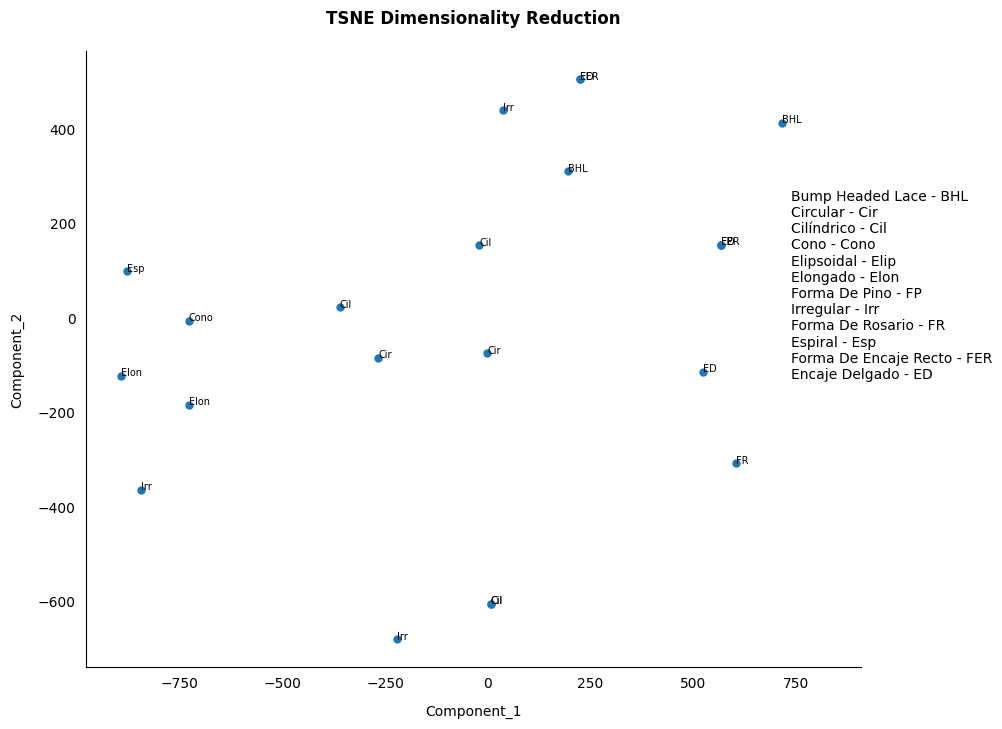

In [7]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Crear el gráfico de dispersión con etiquetas abreviadas y aumentar el tamaño de los puntos
ax.scatter(tsne_df['Component_1'], tsne_df['Component_2'], s=25)  # Ajustar el tamaño de los puntos

# Añadir etiquetas a cada punto
for i in range(len(tsne_df)):
    ax.text(tsne_df['Component_1'][i] + 0.08, tsne_df['Component_2'][i], tsne_df['Abreviatura'][i], fontsize=7)

ax.set_title('TSNE Dimensionality Reduction', pad=20, fontweight='bold')
ax.set_xlabel('Component_1', labelpad=10)
ax.set_ylabel('Component_2', labelpad=10)

# Desactivar las marcas en el eje x de la subgráfica inferior
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y de la subgráfica inferior
ax.tick_params(axis='y', which='both', left=False)
# Mantener solo el borde izquierdo y inferior de la subgráfica inferior
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Crear la caja de texto con el catálogo de nombres y abreviaciones
catalog_text = "\n".join([f"{key} - {value}" for key, value in abbreviation_dict.items()])
fig.text(0.91, 0.62, catalog_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white"))

plt.show()

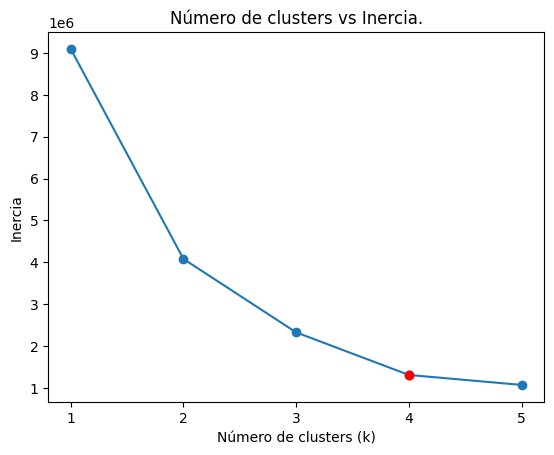

In [8]:
clusters_recomendados, tsne_df["Estrategias"] = kmeans_auto_clusters(tsne_df[['Component_1', 'Component_2']], verbose = False, graph = True)

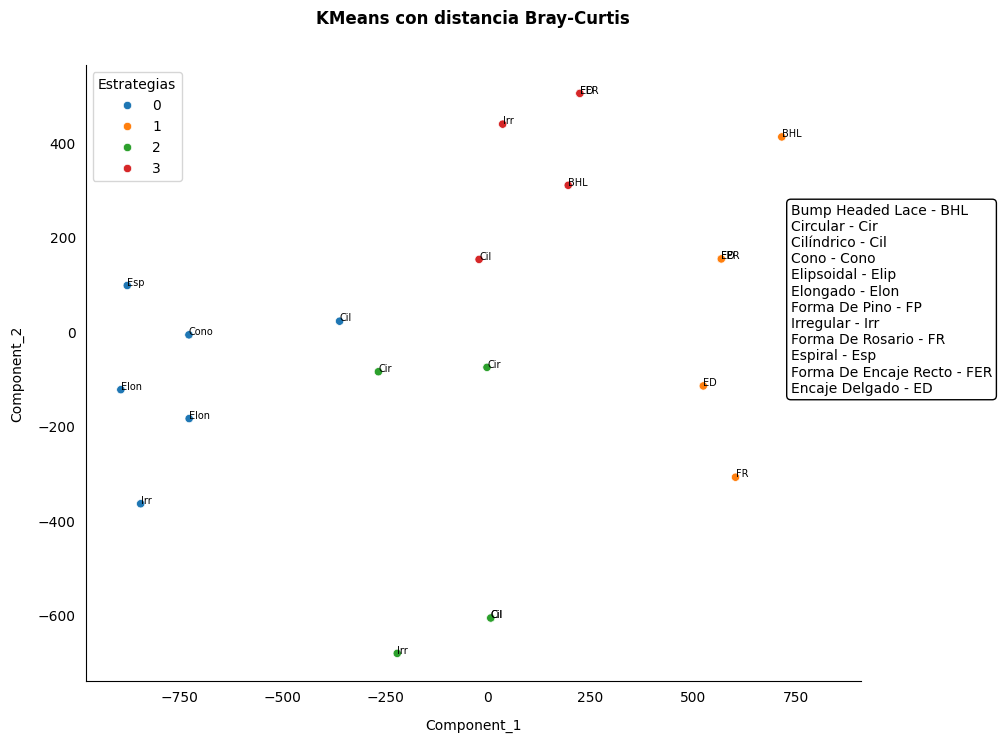

In [9]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Crear el gráfico de dispersión con etiquetas abreviadas y código de color para los clusters
sns.scatterplot(data = tsne_df, x = "Component_1", y = "Component_2", hue = tsne_df["Estrategias"], palette='tab10')

# Añadir etiquetas a cada punto
for i in range(len(tsne_df)):
    ax.text(tsne_df['Component_1'][i] + 0.08, tsne_df['Component_2'][i], tsne_df['Abreviatura'][i], fontsize=7)

ax.set_title('KMeans con distancia Bray-Curtis', pad=30, fontweight='bold')
ax.set_xlabel('Component_1', labelpad=10)
ax.set_ylabel('Component_2', labelpad=10)

# Desactivar las marcas en el eje x de la subgráfica inferior
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y de la subgráfica inferior
ax.tick_params(axis='y', which='both', left=False)
# Mantener solo el borde izquierdo y inferior de la subgráfica inferior
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Crear la caja de texto con el catálogo de nombres y abreviaciones
catalog_text = "\n".join([f"{key} - {value}" for key, value in abbreviation_dict.items()])
fig.text(0.91, 0.62, catalog_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()

In [10]:
fig.savefig('kmeans.png')